# L5 Closed-loop Gym-compatible Environment

This notebook demonstrates some of the aspects of our gym-compatible closed-loop environment.

You will understand the inner workings of our L5Kit environment and an RL policy can be used to rollout the environment. 

Note: The training of different RL policies in our environment will be shown in a separate notebook.

![drivergym](../../../docs/images/rl/drivergym.png)

In [77]:
#@title Download L5 Sample Dataset and install L5Kit
import os
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !wget https://raw.githubusercontent.com/lyft/l5kit/master/examples/setup_notebook_colab.sh -q
    !sh ./setup_notebook_colab.sh
    os.environ["L5KIT_DATA_FOLDER"] = open("./dataset_dir.txt", "r").read().strip()
else:
    # os.environ["L5KIT_DATA_FOLDER"] = "/tmp/level5_data"
    print("Not running in Google Colab.",os.environ["L5KIT_DATA_FOLDER"])

Not running in Google Colab. /home/aswath/Downloads/prediction-dataset


In [78]:
import gym
import matplotlib.pyplot as plt
import torch
import numpy as np

import l5kit.environment
from l5kit.configs import load_config_data
from l5kit.environment.envs.l5_env import EpisodeOutputGym, SimulationConfigGym
from l5kit.environment.gym_metric_set import L2DisplacementYawMetricSet
from l5kit.visualization.visualizer.zarr_utils import episode_out_to_visualizer_scene_gym_cle
from l5kit.visualization.visualizer.visualizer import visualize

from bokeh.io import output_notebook, show
from prettytable import PrettyTable

from IPython.display import clear_output
from collections import deque



### First, let's configure where our data lives!
The data is expected to live in a folder that can be configured using the `L5KIT_DATA_FOLDER` env variable. Your data folder is expected to contain subfolders for the aerial and semantic maps as well as the scenes (`.zarr` files). 
In this example, the env variable is set to the local data folder. You should make sure the path points to the correct location for you.

We built our code to work with a human-readable `yaml` config. This config file holds much useful information, however, we will only focus on a few functionalities concerning the creation of our gym environment here

In [79]:
# Dataset is assumed to be on the folder specified
# in the L5KIT_DATA_FOLDER environment variable

# get environment config
env_config_path = './gym_config.yaml'
cfg = load_config_data(env_config_path)
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 1, 'future_num_frames': 1, 'step_time': 0.1, 'use_kinematic': True, 'render_ego_history': True, 'load_pretrained': False}, 'raster_params': {'raster_size': [112, 112], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False, 'set_origin_to_bottom': True}, 'train_data_loader': {'key': 'scenes/train.zarr'}, 'val_data_loader': {'key': 'scenes/sample.zarr'}, 'gym_params': {'max_scene_id': 1, 'max_val_scene_id': 1, 'randomize_start_frame': False, 'overfit': True, 'overfit_id': 0}}


### We can look into our current configuration for interesting fields

\- when loaded in python, the `yaml`file is converted into a python `dict`. 

`raster_params` contains all the information related to the transformation of the 3D world onto an image plane:
  - `raster_size`: the image plane size
  - `pixel_size`: how many meters correspond to a pixel
  - `ego_center`: our raster is centered around an agent, we can move the agent in the image plane with this param
  - `map_type`: the rasterizer to be employed. We currently support a satellite-based and a semantic-based one. We will look at the differences further down in this script
  
The `raster_params` are used to determine the observation provided by our gym environment to the RL policy.

In [80]:
print(f'current raster_param:\n')
for k,v in cfg["raster_params"].items():
    print(f"{k}:{v}")

current raster_param:

raster_size:[112, 112]
pixel_size:[0.5, 0.5]
ego_center:[0.25, 0.5]
map_type:py_semantic
satellite_map_key:aerial_map/aerial_map.png
semantic_map_key:semantic_map/semantic_map.pb
dataset_meta_key:meta.json
filter_agents_threshold:0.5
disable_traffic_light_faces:False
set_origin_to_bottom:True


## Create L5 Closed-loop Environment

We will now create an instance of the L5Kit gym-compatible environment. As you can see, we need to provide the path to the configuration file of the environment. 

1. The `rescale_action` flag rescales the policy action based on dataset statistics. This argument helps for faster convergence during policy training. 
2. The `return_info` flag informs the environment to return the episode output everytime an episode is rolled out. 

Note: The environment has already been registered with gym during initialization of L5Kit.


In [81]:
env = gym.make("L5-CLE-v0", env_config_path=env_config_path, use_kinematic=True, rescale_action=False, return_info=True)


## Visualize an observation from the environment

Let us visualize the observation from the environment. We will reset the environment and visualize an observation which is provided by the environment.

(3, 112, 112)


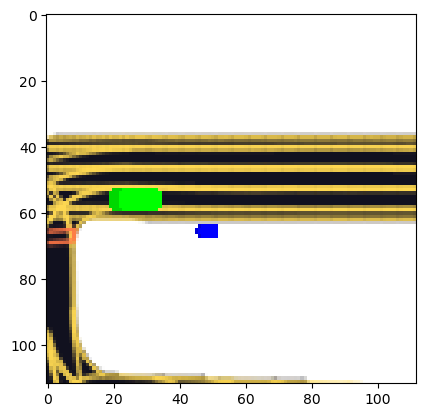

In [82]:
obs = env.reset()
im = obs["image"].transpose(1, 2, 0)
im = env.dataset.rasterizer.to_rgb(im)
print (im.T.shape)

plt.imshow(im)
plt.show()

## Rollout an episode from the environment

### The rollout of an episode in our environment takes place in three steps:

### Gym Environment Update:
1. Reward Calculation (CLE): Given an action from the policy, the environment will calculate the reward received as a consequence of the action.
2. Internal State Update: Since we are rolling out the environment in closed-loop, the internal state of the ego is updated based on the action.
3. Raster rendering: A new raster image is rendered based on the predicted ego position and returned as the observation of next time-step.

### Policy Forward Pass
The policy takes as input the observation provided by the environment and outputs the action via a forward pass.

### Inter-process communication
Usually, we deploy different subprocesses to rollout parallel environments to speed up rollout time during training. Each subprocess rolls out one environemnt. In such scenarios, there is an additional component called inter-process communication: The subprocess outputs (observations) are aggregated and passed to the main process and vice versa (for the actions)

![rollout](../../../docs/images/rl/policy_rollout.png)

### Dummy Policy

For this notebook, we will not train the policy but use a dummy policy. Our dummy policy that will move the ego by 10 m/s along the direction of orientation.

In [83]:
from torch.utils.tensorboard import SummaryWriter
from model.modeling import VisionTransformer, CONFIGS
import argparse
import logging
import sys
import os 

os.environ["CUDA_LAUNCH_BLOCKING"]="1"

sys.argv = ['']

logger = logging.getLogger(__name__)
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

parser = argparse.ArgumentParser()
args = parser.parse_args()
args.model_type = "ViT-toy"
args.pretrained_dir = "./checkpoint/"+args.model_type
args.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = CONFIGS[args.model_type]

def count_parameters(model):
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return params/10e3


model = VisionTransformer(config, zero_head=True)
model.to(args.device)
num_params = count_parameters(model)

logger.info("{}".format(config))
logger.info("Training parameters %s", args)
logger.info("Total Parameter: \t%2.1fK" % num_params)
# model.load_from(np.load(args.pretrained_dir))


2022-04-27 16:18:59,862 | INFO : classifier: token
hidden_size: 50
patches:
  size: !!python/tuple
  - 16
  - 16
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.1
  mlp_dim: 50
  num_heads: 10
  num_layers: 5

2022-04-27 16:18:59,863 | INFO : Training parameters Namespace(device=device(type='cuda'), model_type='ViT-toy', pretrained_dir='./checkpoint/ViT-toy')
2022-04-27 16:18:59,864 | INFO : Total Parameter: 	17.0K


Learn function: learn using the rewards

Q:
$$Q(s_{t},a_{t}) = Q(s_{t},a_{t})+ \alpha(r_{t+1} + \gamma*max_{a}[Q(s_{t},a_{t})] -Q(s_{t},a_{t}) )$$


SARSA:
$$Q(s_{t},a_{t}) = Q(s_{t},a_{t})+ \alpha(r_{t+1} + \gamma*Q(s_{t+1},a_{t+1}) -Q(s_{t},a_{t}) )$$

Bellman equation: 
$$V^{*}(s) = max_{a}{R(s,a) + \gamma \sum P(s_{t+1}|s,a)V^{*}(s_{t+1})} $$

Let us now rollout the environment using the dummy policy. 

In [84]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Visualize the episode from the environment

We can easily visualize the outputs obtained by rolling out episodes in the L5Kit using the Bokeh visualizer.

In [85]:
# might change with different rasterizer
from bokeh.plotting import figure, output_file, save

map_API = env.dataset.rasterizer.sem_rast.mapAPI

def visualize_outputs(sim_outs, map_API):
    for sim_out in sim_outs: # for each scene
        vis_in = episode_out_to_visualizer_scene_gym_cle(sim_out, map_API)
        show(visualize(sim_out.scene_id, vis_in))
        
output_notebook()


Loading BokehJS ...

## Calculate the performance metrics from the episode outputs

We can also calculate the various quantitative metrics on the rolled out episode output. 

In [86]:
def quantify_outputs(sim_outs, metric_set=None):
    metric_set = metric_set if metric_set is not None else L2DisplacementYawMetricSet()

    metric_set.evaluate(sim_outs)
    scene_results = metric_set.evaluator.scene_metric_results
    fields = ["scene_id", "FDE", "ADE"]
    table = PrettyTable(field_names=fields)
    tot_fde = 0.0
    tot_ade = 0.0
    for scene_id in scene_results:
        scene_metrics = scene_results[scene_id]
        ade_error = scene_metrics["displacement_error_l2"][1:].mean()
        fde_error = scene_metrics['displacement_error_l2'][-1]
        table.add_row([scene_id, round(fde_error.item(), 4), round(ade_error.item(), 4)])
        tot_fde += fde_error.item()
        tot_ade += ade_error.item()

    ave_fde = tot_fde / len(scene_results)
    ave_ade = tot_ade / len(scene_results)
    table.add_row(["Overall", round(ave_fde, 4), round(ave_ade, 4)])
    print(table)


In [96]:
prev_loss = -float('inf')
def save_model(model, loss, epoch):
    global prev_loss
    if loss > 0.8*prev_loss or epoch % 1500 ==0:
        prev_loss = loss
        model_to_save = model.module if hasattr(model, 'module') else model
        file_name = f"epoch{epoch}_loss{loss:.4f}_chkpt.pt"
        model_checkpoint = os.path.join("./checkpoints/", file_name)
        torch.save(model_to_save.state_dict(), model_checkpoint)
        logger.info("Saved model checkpoint to [DIR: %s]",model_checkpoint)
        output_file(f"./previews/epoch{epoch}_loss{loss:.4f}_chkpt.html", mode='inline')



In [97]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()


def episode_inference(env, idx, model):
    """Rollout a particular scene index and return the simulation output.

    :param env: the gym environment
    :param idx: the scene index to be rolled out
    :return: the episode output of the rolled out scene
    """

    # Set the reset_scene_id to 'idx'
    env.reset_scene_id = idx
    
    # Rollout step-by-step
    obs = env.reset()
    loss=AverageMeter()
    while True:
        
        # im = obs["image"].transpose(1, 2, 0)
        # im = env.dataset.rasterizer.to_rgb(im)
        # x=torch.tensor(im.T).to(args.device).float()
        # action = model(x.unsqueeze(0))

        obs= obs['image']
        obs = torch.tensor(obs).to(args.device)
        action, _ = model(obs.unsqueeze(0))

        # dummy_action = torch.zeros(3,).to(args.device)
        # dummy_action[...,0] = action[0][...,0]
        # dummy_action[...,1] = action[0][...,1]
        dummy_action = action[0].cpu().detach().numpy()
        # print("Dummy action: ",dummy_action)

        obs, _, done, info = env.step(dummy_action)
        reward_dist = info['reward_dist']
        reward_yaw = info['reward_yaw']

        # reward = np.array()
        reward = torch.tensor([[reward_dist, reward_yaw]], device=args.device, requires_grad=True)
        # print(np.hstack( (dummy_action, np.array([reward_dist, reward_yaw])) ))

        # running_loss = criterion(action[0], reward)
        running_loss = torch.mean(reward) #torch.mean((action[0] -  reward)**2)
        optimizer.zero_grad()
        running_loss.backward()
        optimizer.step()  
        loss.update(running_loss.item())

        if done:
            break
    
    # The episode outputs are present in the key "sim_outs"
    sim_out = info["sim_outs"][0]
    return sim_out, model, loss

# Rollout one episode
simouts = []
losses=[]
circular_queue = deque([], maxlen=5)
epochs=1000
for i in range(epochs):
    clear_output(wait=True)
    simout, model, loss = episode_inference(env, i, model)
    losses.append(loss.avg)
    circular_queue.append(f"Episode: {i+1}, Loss: {loss.avg:.4f}")    
    print("\n".join(circular_queue))
    save_model(model, loss.avg, i)
    # simouts.append(simout)
    # visualize_outputs([simout], map_API)
    # quantify_outputs([simout])

Episode: 996, Loss: -7.0260
Episode: 997, Loss: -6.9809
Episode: 998, Loss: -6.7471
Episode: 999, Loss: -7.0586
Episode: 1000, Loss: -6.8256


In [98]:
model_to_save = model.module if hasattr(model, 'module') else model
file_name = f"FINAL_{epochs}_loss{loss.avg:.4f}_chkpt"
model_checkpoint = "./checkpoints/" + file_name + ".pt"
torch.save(model_to_save.state_dict(), model_checkpoint)
logger.info("Saved model checkpoint to [DIR: %s]",model_checkpoint)

# with open(file_name + ".npz", 'wb') as f:
#     np.save(f, losses)


2022-04-27 16:52:07,778 | INFO : Saved model checkpoint to [DIR: ./checkpoints/FINAL_1000_loss-6.8256_chkpt.pt]


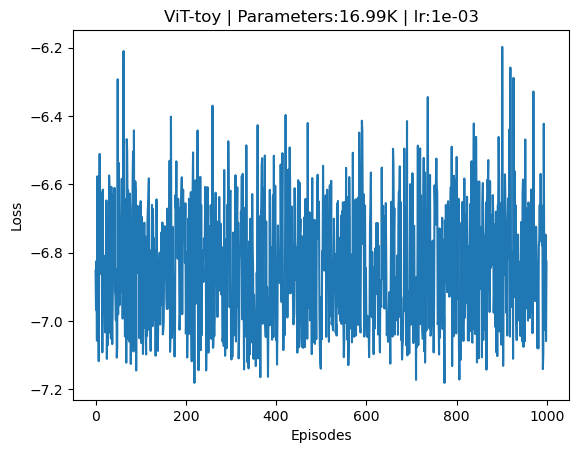

In [100]:
plt_title = args.model_type + " | Parameters:{:.2f}K".format(num_params) + " | lr:{:.0e}".format(learning_rate)
plt.title(plt_title)
plt.ylabel("Loss")
plt.xlabel("Episodes")
plt.plot(losses)
plt.savefig("./previews/"+plt_title+f"loss{loss.avg:.4f}"+".png")
plt.show()
